In [1]:
import bilby
import os
import numpy as np
import healpy as hp
import pandas as pd
import pylab
from astropy.table import Table
import astropy.cosmology as cosmo

name = 'HLV3'
outdir = 'data/simlogs/'+name
bilby.core.utils.setup_logger(outdir=outdir)

duration = 64.0
sampling_frequency = 2048.0
minimum_frequency = 20

run_data = dict()

<h2>Pick a galaxy from the catalog and generate event parameters</h2>

In [2]:
catalog = Table.read('data/catalog_fullsky_zsm1.fits.gz').to_pandas()

ra = catalog['RA'].values
dec = catalog['DEC'].values
z = catalog['REDSHIFT'].values

mask = (z<0.08) & (ra>0) & (ra<360) & (np.abs(dec)<90)

ra = ra[mask] * np.pi / 180
dec = dec[mask] * np.pi / 180
z = z[mask]

cosmology = cosmo.WMAP7
bilby.gw.cosmology.set_cosmology(cosmology=cosmology)

dl = bilby.gw.conversion.redshift_to_luminosity_distance(z)

In [3]:
data_check = pd.read_csv('data/injection_parameters.csv')

for key in data_check:
    if key == 'id':
        data_check[key] = np.array(data_check[key]).astype('str')
    elif key == 'index':
        data_check[key] = np.array(data_check[key]).astype('int')
    else:
        data_check[key] = np.array(data_check[key]).astype('float')

if name in data_check['id'].values:
    injection_parameters = dict(mass_1=float(data_check['mass_1'][data_check['id']==name]),
                                mass_2=float(data_check['mass_2'][data_check['id']==name]),
                                a_1=float(data_check['a_1'][data_check['id']==name]),
                                a_2=float(data_check['a_2'][data_check['id']==name]),
                                tilt_1=float(data_check['tilt_1'][data_check['id']==name]),
                                tilt_2=float(data_check['tilt_2'][data_check['id']==name]),
                                phi_12=float(data_check['phi_12'][data_check['id']==name]),
                                phi_jl=float(data_check['phi_jl'][data_check['id']==name]),
                                luminosity_distance=float(data_check['luminosity_distance'][data_check['id']==name]),
                                theta_jn=float(data_check['theta_jn'][data_check['id']==name]),
                                psi=float(data_check['psi'][data_check['id']==name]),
                                phase=float(data_check['phase'][data_check['id']==name]),
                                geocent_time=float(data_check['geocent_time'][data_check['id']==name]),
                                ra=float(data_check['ra'][data_check['id']==name]),
                                dec=float(data_check['dec'][data_check['id']==name])
                               )
    
    run_data['index'] = int(data_check['index'][data_check['id']==name])
    run_data['id'] = name
    for key in injection_parameters:
        run_data[key] = injection_parameters[key]
else:
    masses = np.random.uniform(1.5,10,2)
    index = np.random.randint(0, len(z))
    sindist = bilby.core.prior.Sine()
    cosdist = bilby.core.prior.Cosine()
    
    injection_parameters = dict(mass_1=np.max(masses),
                                mass_2=np.min(masses),
                                a_1=np.random.uniform(0, 0.99),
                                a_2=np.random.uniform(0, 0.99),
                                tilt_1=sindist.sample(),
                                tilt_2=sindist.sample(),
                                phi_12=np.random.uniform(0, 2*np.pi),
                                phi_jl=np.random.uniform(0, 2*np.pi),
                                luminosity_distance=dl[index],
                                theta_jn=sindist.sample(),
                                psi=np.random.uniform(0, np.pi),
                                phase=np.random.uniform(0, 2*np.pi),
                                geocent_time=np.random.uniform(1.1e9, 1.2e9),
                                ra=ra[index],
                                dec=dec[index]
                               )
    
    run_data['index'] = index
    run_data['id'] = name
    for key in injection_parameters:
        run_data[key] = injection_parameters[key]

    pd.DataFrame([run_data]).to_csv('data/injection_parameters.csv', mode='a', index=False, header=False)

FileNotFoundError: [Errno 2] No such file or directory: 'data/injection_parameters.csv'

<h2>Uniform All-Sky Distribution Run</h2>

In [8]:
waveform_arguments = dict(waveform_approximant="IMRPhenomPv2",
                          reference_frequency=50.0,
                          minimum_frequency=minimum_frequency,
                          catch_waveform_errors=True
                         )

waveform_generator = bilby.gw.WaveformGenerator(duration=duration,
                                                sampling_frequency=sampling_frequency,
                                                frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
                                                parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
                                                waveform_arguments=waveform_arguments
                                               )

ifos = bilby.gw.detector.InterferometerList(["H1", "L1", "V1"])

ifos.set_strain_data_from_power_spectral_densities(sampling_frequency=sampling_frequency,
                                                   duration=duration,
                                                   start_time=injection_parameters["geocent_time"] - 2
                                                  )

ifos.inject_signal(waveform_generator=waveform_generator, parameters=injection_parameters)

if os.path.isfile(".distance_marginalization_lookup.npz"):
    os.remove(".distance_marginalization_lookup.npz")
    print("Distance Lookup Tables Deleted")
else:
    print("No Distance Lookup Tables Found")

11:35 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
11:35 bilby INFO    : Injected signal in H1:
11:35 bilby INFO    :   optimal SNR = 11.39
11:35 bilby INFO    :   matched filter SNR = 10.77+0.63j
11:35 bilby INFO    :   mass_1 = 9.723127204017764
11:35 bilby INFO    :   mass_2 = 6.908946508001228
11:35 bilby INFO    :   a_1 = 0.8163171279211631
11:35 bilby INFO    :   a_2 = 0.16764960103382612
11:35 bilby INFO    :   tilt_1 = 1.2386480681628023
11:35 bilby INFO    :   tilt_2 = 2.110302312653431
11:35 bilby INFO    :   phi_12 = 4.961847457445274
11:35 bilby INFO    :   phi_jl = 0.5226623723838439
11:35 bilby INFO    :   luminosity_distance = 312.30445624894014
11:35 bilby INFO    :   theta_jn = 1.724365965248175
11:35 bilby INFO    :   psi = 2.4870657197308
11:35 bilby INFO    :   phase = 0.8

No Distance Lookup Tables Found


In [5]:
#! rm .distance_marginalization_lookup.npz

rm: cannot remove '.distance_marginalization_lookup.npz': No such file or directory


In [6]:
#prior = bilby.gw.prior.BBHPriorDict()

#prior["mass_ratio"] = bilby.core.prior.Uniform(minimum=0.7, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
#prior["chirp_mass"] = bilby.core.prior.Uniform(minimum=20, maximum=40, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)

In [7]:
prior = bilby.gw.prior.PriorDict()

prior["mass_ratio"] = bilby.core.prior.Uniform(name='mass_ratio', minimum=0.15, maximum=1)
prior["chirp_mass"] = bilby.core.prior.Uniform(name='chirp_mass', minimum=1.3, maximum=8.71)
prior["mass_1"] = bilby.core.prior.Constraint(name='mass_1', minimum=1.3, maximum=12)
prior["mass_2"] = bilby.core.prior.Constraint(name='mass_2', minimum=1.3, maximum=12)
prior["a_1"] = bilby.core.prior.Uniform(name='a_1', minimum=0, maximum=0.99)
prior["a_2"] = bilby.core.prior.Uniform(name='a_2', minimum=0, maximum=0.99)
prior["tilt_1"] = bilby.core.prior.Sine(name='tilt_1')
prior["tilt_2"] = bilby.core.prior.Sine(name='tilt_2')
prior["phi_12"] = bilby.core.prior.Uniform(name='phi_12', minimum=0, maximum=2 * np.pi, boundary='periodic')
prior["phi_jl"] = bilby.core.prior.Uniform(name='phi_jl', minimum=0, maximum=2 * np.pi, boundary='periodic')
prior["dec"] = bilby.core.prior.Cosine(name='dec')
prior["ra"] = bilby.core.prior.Uniform(name='ra', minimum=0, maximum=2 * np.pi, boundary='periodic')
prior["theta_jn"] = bilby.core.prior.Sine(name='theta_jn')
prior["psi"] = bilby.core.prior.Uniform(name='psi', minimum=0, maximum=np.pi, boundary='periodic')
prior["phase"] = bilby.core.prior.Uniform(name='phase', minimum=0, maximum=2 * np.pi, boundary='periodic')

prior["luminosity_distance"] = bilby.gw.prior.UniformSourceFrame(name='luminosity_distance', minimum=2e1, maximum=4e2, unit='Mpc', latex_label='$d_L$')
prior["geocent_time"] = bilby.core.prior.Uniform(injection_parameters['geocent_time']-0.1, injection_parameters['geocent_time']+0.1, name="geocent_time")

likelihood = bilby.gw.GravitationalWaveTransient(interferometers=ifos, waveform_generator=waveform_generator, priors=prior,
                                                 time_marginalization=True, phase_marginalization=False, distance_marginalization=True)

14:25 bilby INFO    : No prior given, using default BBH priors in /home/imcmahon/mambaforge/envs/bbh_inference/lib/python3.10/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.
14:25 bilby INFO    : Distance marginalisation file .distance_marginalization_lookup.npz does not exist
14:25 bilby INFO    : Building lookup table for distance marginalisation.


  0%|          | 0/400 [00:00<?, ?it/s]

In [8]:
result = bilby.run_sampler(likelihood=likelihood,
                           priors=prior,
                           sampler="dynesty",
                           npoints=300,
                           injection_parameters=injection_parameters,
                           outdir=outdir,
                           label=name+'-injection-uniform',
                           conversion_function=bilby.gw.conversion.generate_all_bbh_parameters
                          )

14:25 bilby INFO    : Running for label 'HL9-injection-uniform', output will be saved to 'data/simlogs/HL9'
14:25 bilby INFO    : Using lal version 7.2.0
14:25 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.2.0;Id: 95de40ca534988dcfbd7eb45d34ec6fa6b799dc9;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
14:25 bilby INFO    : Using lalsimulation version 4.0.0
14:25 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v4.0.0;Id: 5ac73c7a1e5e60914aa50429490ce0a75300f24a;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
14:25 bilby INFO    : Search parameters:
14:25 bilby INFO    :   dec = Cosine(minimum=-1.5707963267948966, maximum=1.5707963267948966, name='dec', latex_label='$\\mathrm{DEC}$', unit=None, boundary=None)
14:25 bilby INFO    :   ra = Uniform(minimum=0, maximum=6.283185307179586, name='ra', latex_label='$\\mathrm{RA}$', unit=None, bound

0it [00:00, ?it/s]

14:25 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 500, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f9a10844550>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5, 'print_method': 'tqdm'}
14:25 bilby INFO    : Checkpoint every check_point_delta_t = 600s
14:25 bilby INFO    : Using dynesty version 1.0.1
14:25 bilby INFO    : Using the bil

/home/imcmahon/mambaforge/envs/bbh_inference/lib/python3.10/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)
14:49 bilby INFO    : Sampling time: 0:24:09.098083
/home/imcmahon/mambaforge/envs/bbh_inference/lib/python3.10/site-packages/bilby/core/result.py:1453: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  if "npool" in inspect.getargspec(conversion_function).args:
14:49 bilby INFO    : Reconstru

  0%|          | 0/6968 [00:00<?, ?it/s]

14:50 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/6968 [00:00<?, ?it/s]

14:50 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/6968 [00:00<?, ?it/s]

14:51 bilby INFO    : Summary of results:
nsamples: 6968
ln_noise_evidence: -8286.292
ln_evidence: -8045.372 +/-  0.193
ln_bayes_factor: 240.920 +/-  0.193



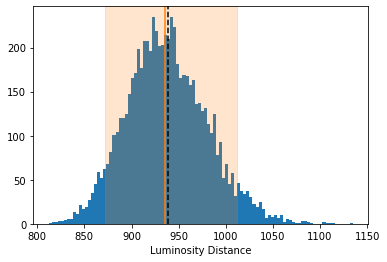

In [9]:
dl = result.posterior["luminosity_distance"].values
lower_bound = np.quantile(dl, 0.05)
upper_bound = np.quantile(dl, 0.95)
median = np.median(dl)
mean = np.mean(dl)
std = np.std(dl)

run_data['un_dl_med'] = median
run_data['un_dl_upper'] = upper_bound
run_data['un_dl_lower'] = lower_bound
run_data['un_dl_avg'] = mean
run_data['un_dl_std'] = std

fig, ax = pylab.subplots()
ax.hist(dl, bins=100)
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.2)
ax.axvline(median, color='C1')
ax.axvline(injection_parameters['luminosity_distance'], color='k', linestyle='--')
ax.set_xlabel("Luminosity Distance")
pylab.show()

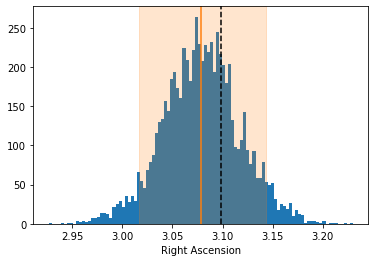

In [10]:
ra = result.posterior["ra"].values
lower_bound = np.quantile(ra, 0.05)
upper_bound = np.quantile(ra, 0.95)
median = np.median(ra)
mean = np.mean(ra)
std = np.std(ra)

run_data['un_ra_med'] = median
run_data['un_ra_upper'] = upper_bound
run_data['un_ra_lower'] = lower_bound
run_data['un_ra_avg'] = mean
run_data['un_ra_std'] = std

fig, ax = pylab.subplots()
ax.hist(ra, bins=100)
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.2)
ax.axvline(median, color='C1')
ax.axvline(injection_parameters['ra'], color='k', linestyle='--')
ax.set_xlabel("Right Ascension")
pylab.show()

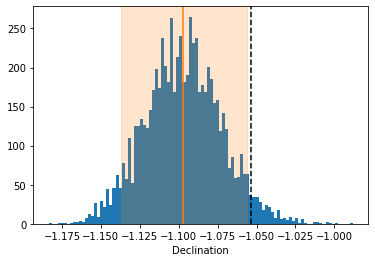

In [11]:
dec = result.posterior["dec"].values
lower_bound = np.quantile(dec, 0.05)
upper_bound = np.quantile(dec, 0.95)
median = np.median(dec)
mean = np.mean(dec)
std = np.std(dec)

run_data['un_dec_med'] = median
run_data['un_dec_upper'] = upper_bound
run_data['un_dec_lower'] = lower_bound
run_data['un_dec_avg'] = mean
run_data['un_dec_std'] = std

fig, ax = pylab.subplots()
ax.hist(dec, bins=100)
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.2)
ax.axvline(median, color='C1')
ax.axvline(injection_parameters['dec'], color='k', linestyle='--')
ax.set_xlabel("Declination")
pylab.show()

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


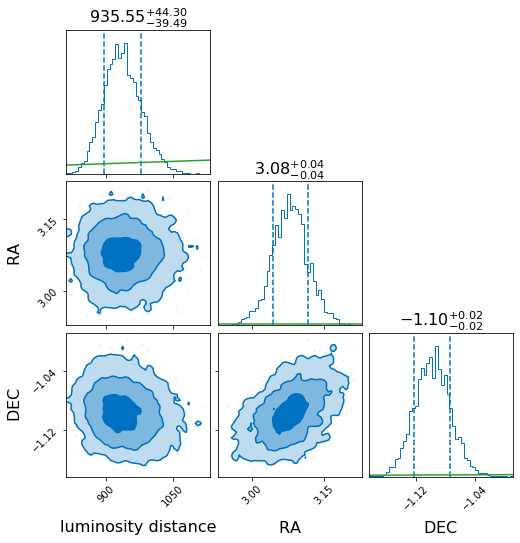

In [12]:
result.plot_corner(parameters=["luminosity_distance", "ra", 'dec'], priors=prior)

In [13]:
result.save_posterior_samples()

14:51 bilby INFO    : Writing samples file to /home/imcmahon/Documents/skymap-inference/injection_simulation/data/simlogs/HL9/HL9-injection-uniform_posterior_samples.dat


<h2>HEALPix Run</h2>

In [14]:
waveform_arguments = dict(waveform_approximant="IMRPhenomPv2",
                          reference_frequency=50.0,
                          minimum_frequency=minimum_frequency
                         )

waveform_generator = bilby.gw.WaveformGenerator(duration=duration,
                                                sampling_frequency=sampling_frequency,
                                                frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
                                                parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
                                                waveform_arguments=waveform_arguments
                                               )

ifos = bilby.gw.detector.InterferometerList(["H1", "L1", "V1"])

ifos.set_strain_data_from_power_spectral_densities(sampling_frequency=sampling_frequency,
                                                   duration=duration,
                                                   start_time=injection_parameters["geocent_time"] - 2
                                                  )

ifos.inject_signal(waveform_generator=waveform_generator, parameters=injection_parameters)

if os.path.isfile(".distance_marginalization_lookup.npz"):
    os.remove(".distance_marginalization_lookup.npz")
    print("Distance Lookup Tables Deleted")
else:
    print("No Distance Lookup Tables Found")

14:51 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
14:51 bilby INFO    : Injected signal in H1:
14:51 bilby INFO    :   optimal SNR = 18.12
14:51 bilby INFO    :   matched filter SNR = 18.03+1.13j
14:51 bilby INFO    :   mass_1 = 28.824754726691847
14:51 bilby INFO    :   mass_2 = 26.3933214741802
14:51 bilby INFO    :   a_1 = 0.6243727594321817
14:51 bilby INFO    :   a_2 = 0.6671925063278527
14:51 bilby INFO    :   tilt_1 = 1.1339688641662116
14:51 bilby INFO    :   tilt_2 = 1.3093012052160118
14:51 bilby INFO    :   phi_12 = 4.668446143528956
14:51 bilby INFO    :   phi_jl = 2.9578004135771554
14:51 bilby INFO    :   luminosity_distance = 938.293121869594
14:51 bilby INFO    :   theta_jn = 1.0405337309194802
14:51 bilby INFO    :   psi = 1.562349977963821
14:51 bilby INFO    :   phase = 1.

[{'plus': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
  'cross': array([0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j])},
 {'plus': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
  'cross': array([0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j])}]

In [15]:
#! rm .distance_marginalization_lookup.npz

In [16]:
#prior = bilby.gw.prior.BBHPriorDict()
#prior["mass_ratio"] = bilby.core.prior.Uniform(minimum=0.7, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
#prior["chirp_mass"] = bilby.core.prior.Uniform(minimum=20, maximum=40, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)

In [17]:
prior = bilby.gw.prior.PriorDict()

prior["mass_ratio"] = bilby.core.prior.Uniform(name='mass_ratio', minimum=0.15, maximum=1)
prior["chirp_mass"] = bilby.core.prior.Uniform(name='chirp_mass', minimum=1.3, maximum=8.71)
prior["mass_1"] = bilby.core.prior.Constraint(name='mass_1', minimum=1.3, maximum=12)
prior["mass_2"] = bilby.core.prior.Constraint(name='mass_2', minimum=1.3, maximum=12)
prior["a_1"] = bilby.core.prior.Uniform(name='a_1', minimum=0, maximum=0.99)
prior["a_2"] = bilby.core.prior.Uniform(name='a_2', minimum=0, maximum=0.99)
prior["tilt_1"] = bilby.core.prior.Sine(name='tilt_1')
prior["tilt_2"] = bilby.core.prior.Sine(name='tilt_2')
prior["phi_12"] = bilby.core.prior.Uniform(name='phi_12', minimum=0, maximum=2 * np.pi, boundary='periodic')
prior["phi_jl"] = bilby.core.prior.Uniform(name='phi_jl', minimum=0, maximum=2 * np.pi, boundary='periodic')
prior["theta_jn"] = bilby.core.prior.Sine(name='theta_jn')
prior["psi"] = bilby.core.prior.Uniform(name='psi', minimum=0, maximum=np.pi, boundary='periodic')
prior["phase"] = bilby.core.prior.Uniform(name='phase', minimum=0, maximum=2 * np.pi, boundary='periodic')

prior["luminosity_distance"] = bilby.gw.prior.UniformSourceFrame(name='luminosity_distance', minimum=2e1, maximum=4e2, unit='Mpc', latex_label='$d_L$')
prior["geocent_time"] = bilby.core.prior.Uniform(injection_parameters['geocent_time']-0.1, injection_parameters['geocent_time']+0.1, name="geocent_time")

hp_prior = bilby.gw.prior.HealPixMapPriorDist('data/catalog_skymap.fits', names=['ra', 'dec'], bounds={'ra': (0, 2*np.pi), 'dec': (-np.pi/2, np.pi/2)})
prior["ra"] = bilby.gw.prior.HealPixPrior(hp_prior, 'ra')
prior["dec"] = bilby.gw.prior.HealPixPrior(hp_prior, 'dec')

likelihood = bilby.gw.GravitationalWaveTransient(interferometers=ifos, waveform_generator=waveform_generator, priors=prior,
                                                 time_marginalization=True, phase_marginalization=False, distance_marginalization=True)

14:51 bilby INFO    : Distance marginalisation file .distance_marginalization_lookup.npz does not exist
14:51 bilby INFO    : Building lookup table for distance marginalisation.


  0%|          | 0/400 [00:00<?, ?it/s]

In [18]:
result_hp = bilby.run_sampler(likelihood=likelihood,
                           priors=prior,
                           sampler="dynesty",
                           npoints=300,
                           injection_parameters=injection_parameters,
                           outdir=outdir,
                           label=name+'-injection-healpix',
                           conversion_function=bilby.gw.conversion.generate_all_bbh_parameters
                          )

14:51 bilby INFO    : Running for label 'HL9-injection-healpix', output will be saved to 'data/simlogs/HL9'
14:51 bilby INFO    : Using lal version 7.2.0
14:51 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.2.0;Id: 95de40ca534988dcfbd7eb45d34ec6fa6b799dc9;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
14:51 bilby INFO    : Using lalsimulation version 4.0.0
14:51 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v4.0.0;Id: 5ac73c7a1e5e60914aa50429490ce0a75300f24a;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
14:51 bilby INFO    : Search parameters:
14:51 bilby INFO    :   ra = HealPixPrior(dist=HealPixMapPriorDist(hp_file='data/catalog_skymap.fits', names=['ra', 'dec'], bounds={'ra': (0, 6.283185307179586), 'dec': (-1.5707963267948966, 1.5707963267948966)}, distance=False), name='ra', latex_label='$\\mathrm{RA}$', unit=None)
14:51 bilby I

0it [00:00, ?it/s]

14:51 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 500, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f9aa3f97f70>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5, 'print_method': 'tqdm'}
14:51 bilby INFO    : Checkpoint every check_point_delta_t = 600s
14:51 bilby INFO    : Using dynesty version 1.0.1
14:51 bilby INFO    : Using the bil

/home/imcmahon/mambaforge/envs/bbh_inference/lib/python3.10/site-packages/dynesty/utils.py:171: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  idx = np.zeros(nsamples, dtype=np.int)
15:25 bilby INFO    : Sampling time: 0:33:06.507253
/home/imcmahon/mambaforge/envs/bbh_inference/lib/python3.10/site-packages/bilby/core/result.py:1453: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  if "npool" in inspect.getargspec(conversion_function).args:
15:25 bilby INFO    : Reconstru

  0%|          | 0/7197 [00:00<?, ?it/s]

15:26 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/7197 [00:00<?, ?it/s]

15:26 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/7197 [00:00<?, ?it/s]

15:26 bilby INFO    : Summary of results:
nsamples: 7197
ln_noise_evidence: -8236.595
ln_evidence: -8020.489 +/-  0.193
ln_bayes_factor: 216.107 +/-  0.193



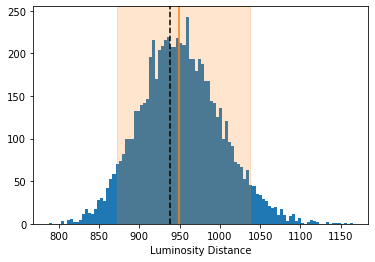

In [19]:
dl = result_hp.posterior["luminosity_distance"].values
lower_bound = np.quantile(dl, 0.05)
upper_bound = np.quantile(dl, 0.95)
median = np.median(dl)
mean = np.mean(dl)
std = np.std(dl)

run_data['hp_dl_med'] = median
run_data['hp_dl_upper'] = upper_bound
run_data['hp_dl_lower'] = lower_bound
run_data['hp_dl_avg'] = mean
run_data['hp_dl_std'] = std

fig, ax = pylab.subplots()
ax.hist(dl, bins=100)
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.2)
ax.axvline(median, color='C1')
ax.axvline(injection_parameters['luminosity_distance'], color='k', linestyle='--')
ax.set_xlabel("Luminosity Distance")
pylab.show()

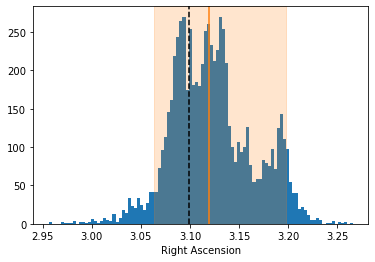

In [20]:
ra = result_hp.posterior["ra"].values
lower_bound = np.quantile(ra, 0.05)
upper_bound = np.quantile(ra, 0.95)
median = np.median(ra)
mean = np.mean(ra)
std = np.std(ra)

run_data['hp_ra_med'] = median
run_data['hp_ra_upper'] = upper_bound
run_data['hp_ra_lower'] = lower_bound
run_data['hp_ra_avg'] = mean
run_data['hp_ra_std'] = std

fig, ax = pylab.subplots()
ax.hist(ra, bins=100)
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.2)
ax.axvline(median, color='C1')
ax.axvline(injection_parameters['ra'], color='k', linestyle='--')
ax.set_xlabel("Right Ascension")
pylab.show()

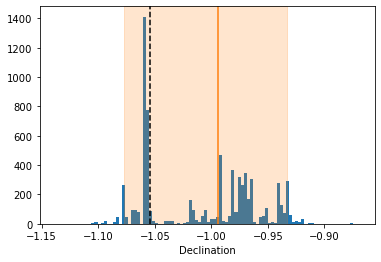

In [21]:
dec = result_hp.posterior["dec"].values
lower_bound = np.quantile(dec, 0.05)
upper_bound = np.quantile(dec, 0.95)
median = np.median(dec)
mean = np.mean(dec)
std = np.std(dec)

run_data['hp_dec_med'] = median
run_data['hp_dec_upper'] = upper_bound
run_data['hp_dec_lower'] = lower_bound
run_data['hp_dec_avg'] = mean
run_data['hp_dec_std'] = std

fig, ax = pylab.subplots()
ax.hist(dec, bins=100)
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.2)
ax.axvline(median, color='C1')
ax.axvline(injection_parameters['dec'], color='k', linestyle='--')
ax.set_xlabel("Declination")
pylab.show()

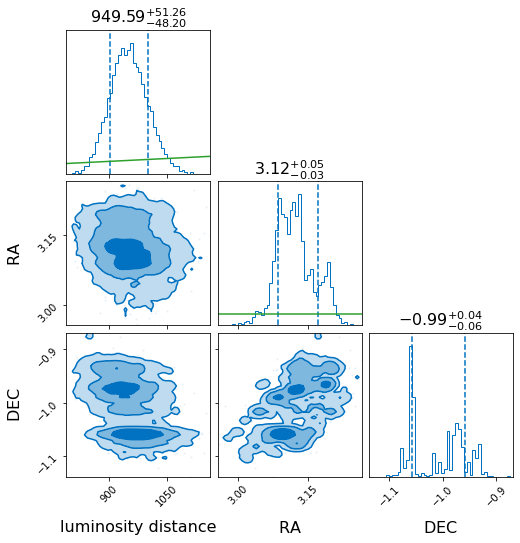

In [22]:
result_hp.plot_corner(parameters=["luminosity_distance", "ra", 'dec'], priors=prior)

In [23]:
result_hp.save_posterior_samples()

15:26 bilby INFO    : Writing samples file to /home/imcmahon/Documents/skymap-inference/injection_simulation/data/simlogs/HL9/HL9-injection-healpix_posterior_samples.dat


<h2>Save Results</h2>

In [24]:
pd.DataFrame([run_data]).to_csv('data/sim_results.csv', mode='a', index=False, header=False)